# Imports


In [2]:
import warnings
import h3
import ee
import google
import os
import folium

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tobler.util import h3fy
from shapely.wkt import loads

In [3]:
ee.Authenticate()

Enter verification code: 4/1AZEOvhW1NdXoHFNhDGCBHWivONKnxbw3aX7_1DvgVvZH9EzJqThlLLJhuWA

Successfully saved authorization token.


In [47]:
ee.Initialize()

In [48]:
try:
  import ee_jupyter
except ModuleNotFoundError:
  print('ee_jupyter was not found. Installing now...')
  result = os.system('pip -q install earthengine-jupyter')
  import ee_jupyter
print(f'ee_jupyter (version {ee_jupyter.__version__}) '
        f'is installed.')

ee_jupyter (version 0.0.7) is installed.


In [49]:
from ee_jupyter.ipyleaflet import Map

In [50]:
warnings.filterwarnings('ignore')

# Import Temperature Data and Set Up Map

In [89]:
# kelvin air temperature for Feburary 1, 7 AM
kelvin_air_temp = ee.Image('ECMWF/ERA5_LAND/HOURLY/20230201T07').select('temperature_2m')
farenheit_air_temp = kelvin_air_temp.multiply(1.8).subtract(459.67)

In [96]:
location_lonlat= [-134.424637, 58.301041]
map_init_params = {
    'center': list(reversed(location_lonlat)), # <lat,lon> ordering
    'zoom': 3
}
map1 = Map(**map_init_params)

In [97]:
map1.addLayer(
  kelvin_air_temp,
  {'min': 233, 'max': 270, 'palette': ['grey', 'blue']}, # remember temperature here is in Kelvin
  'air temperature (Kelvin)'
)

In [103]:
map1.addLayer(
  farenheit_air_temp,
  {'min': -40, 'max': 26, 'palette': ['white', 'green']}, # remember temperature here is in Farenheit
  'air temperature (Farenheit)'
)

# Census Tract (2020)

In [104]:
tracts_feature = ee.FeatureCollection("TIGER/2020/TRACT")
ak_tracts = tracts_feature.filter(ee.Filter.equals('STATEFP', '02'))

In [105]:
ak_tracts.size().getInfo()

177

In [101]:
style = {'color': '0000ffff', 'width': 2, 'lineType': 'solid', 'fillColor': '00000080'}
map1.addLayer(ak_tracts.style(**style), {}, "Census Tracts")

In [106]:
map1

Map(bottom=1318.0, center=[62.99515845212052, -148.35626733635596], controls=(ZoomControl(options=['position',…

In [107]:
reduced_temp_tract = kelvin_air_temp.reduceRegions(ak_tracts, ee.Reducer.mean())

In [108]:
print(type(reduced_temp_tract))
print(type(reduced_temp_tract.first()))
# find the smallest and biggest man temperature across alaska for this time period
print(reduced_temp_tract.aggregate_max('mean').getInfo())
print(reduced_temp_tract.aggregate_min('mean').getInfo())

<class 'ee.featurecollection.FeatureCollection'>
<class 'ee.element.Element'>
277.0482484615049
248.8814080047562


In [109]:
tract_map = Map(**map_init_params)

empty = ee.Image().byte()
fills_tract = empty.paint(
  featureCollection = reduced_temp_tract,
  color = 'mean',
)
tract_map.addLayer(fills_tract, {'palette': ['white', 'red'], 'min': 247, 'max': 277.5}, 'mean temp by census tract')

In [110]:
tract_map

Map(center=[58.301041, -134.424637], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [62]:
task = ee.batch.Export.table.toDrive(**{
  'collection': reduced_temp_tract,
  'description': 'Tract Average Temp',
  'folder': 'EarthEngine',
  'fileFormat': 'CSV'
})
task.start()

# Census Boroughs (2018)

In [111]:
census_boroughs = ee.FeatureCollection("TIGER/2018/Counties")
ak_boroughs = census_boroughs.filter(ee.Filter.equals('STATEFP', '02'))

In [64]:
ak_boroughs.size().getInfo()

29

In [65]:
reduced_temp_borough = kelvin_air_temp.reduceRegions(ak_tracts, ee.Reducer.mean())

In [66]:
borough_map = Map(**map_init_params)

empty = ee.Image().byte()
fills_borough = empty.paint(
  featureCollection = reduced_temp_borough,
  color = 'mean',
)
borough_map.addLayer(fills_borough, {'palette': ['white', 'red'], 'min': 247, 'max': 277.5}, 'mean temp by borough')

In [67]:
borough_map

Map(center=[58.301041, -134.424637], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [68]:
task = ee.batch.Export.table.toDrive(**{
  'collection': reduced_temp_borough,
  'description': 'Borough Average Temp',
  'folder': 'EarthEngine',
  'fileFormat': 'CSV'
})
task.start()

# Census Block Groups (2020)

This is a little slower than the above calculations, but not too bad.

In [69]:
census_bg = ee.FeatureCollection("TIGER/2020/BG")
ak_bg = census_bg.filter(ee.Filter.equals('STATEFP', '02'))
ak_bg.size().getInfo()

504

In [70]:
reduced_temp_bg = kelvin_air_temp.reduceRegions(ak_bg, ee.Reducer.mean())

In [71]:
bg_map = Map(**map_init_params)

empty = ee.Image().byte()
fills_bg = empty.paint(
  featureCollection = reduced_temp_bg,
  color = 'mean',
)
bg_map.addLayer(fills_bg, {'palette': ['white', 'red'], 'min': 247, 'max': 277.5}, 'mean temp by census block group')

In [72]:
bg_map

Map(center=[58.301041, -134.424637], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [73]:
task = ee.batch.Export.table.toDrive(**{
  'collection': reduced_temp_bg,
  'description': 'Block Group Average Temp',
  'folder': 'EarthEngine',
  'fileFormat': 'CSV'
})
task.start()

# Hexagons!!

In [74]:
latitude_fairbanks = 64.837776
longitude_fairbanks = -147.716385
hex_id = h3.geo_to_h3(latitude_fairbanks, longitude_fairbanks, resolution=4)
geometry = Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True))

<AxesSubplot: >

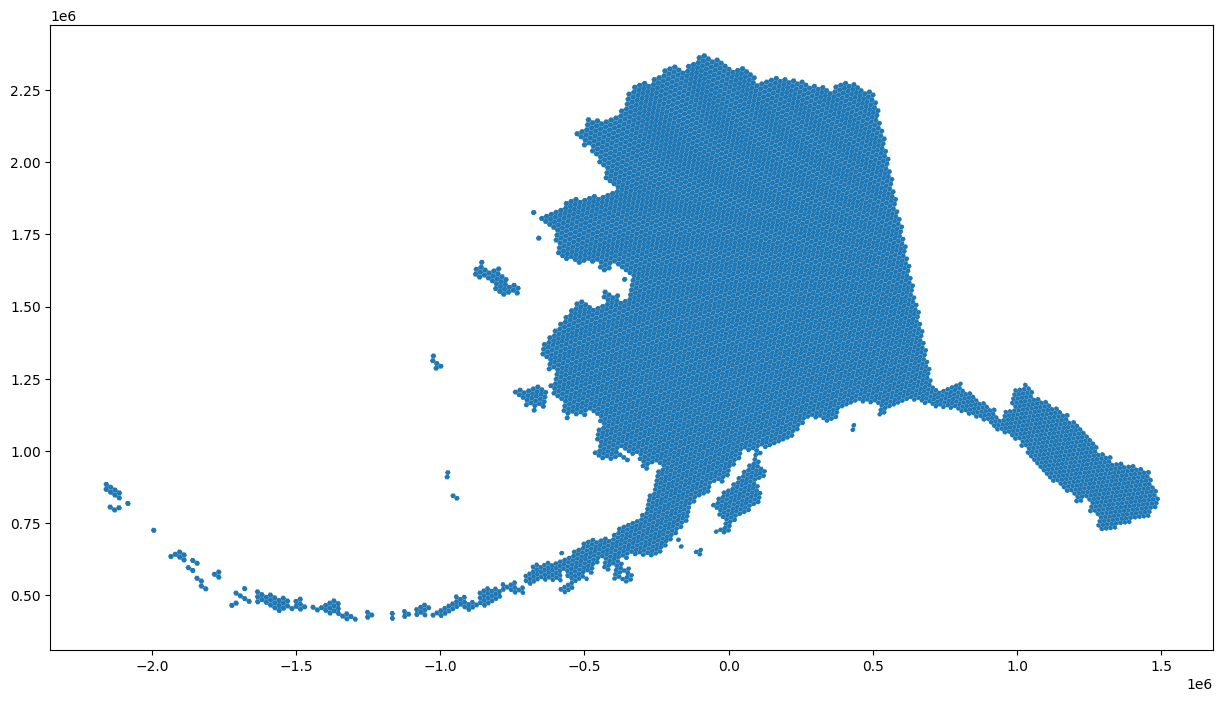

In [75]:
# get the following shape file from
# https://live.laborstats.alaska.gov/cen/maps/gis/Boroughs2020.zip
# hosted at
# https://live.laborstats.alaska.gov/cen/maps-gis

geodf = gpd.read_file('../Data/Boroughs2020/Boroughs2020.shp')
hexgrid_res5 = h3fy(geodf.buffer(0.01), resolution=5)
hexgrid_res5.plot(figsize=(15,15))

<AxesSubplot: >

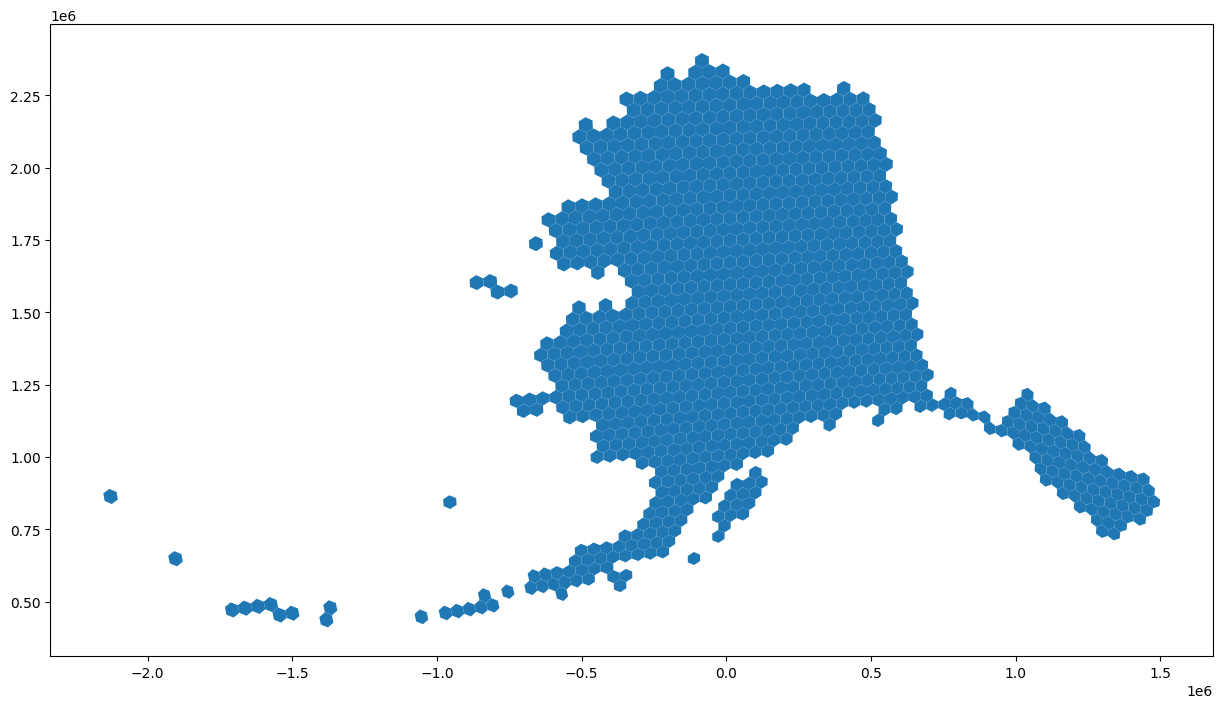

In [76]:
hexgrid_res4 = h3fy(geodf.buffer(0.01), resolution=4)
hexgrid_res4.plot(figsize=(15,15))

In [77]:
hexgrid_res4.size

1037

In [78]:
hexgrid_res5.size

7291

In [79]:
geodf = geodf.to_crs(4326)
hexgrid_res5_4326 = h3fy(geodf.buffer(0.01), resolution=5)
hexgrid_res4_4326 = h3fy(geodf.buffer(0.01), resolution=4)

In [80]:
def get_ee_feature(geom):
    x,y = geom.exterior.coords.xy
    coords = np.dstack((x,y)).tolist()
    g = ee.Geometry.Polygon(coords)
    return ee.Feature(g)
features5 = ee.FeatureCollection([get_ee_feature(x[1].geometry) for x in hexgrid_res5_4326.iterrows()])
features4 = ee.FeatureCollection([get_ee_feature(x[1].geometry) for x in hexgrid_res4_4326.iterrows()])

In [113]:
image_collection = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY")
image = image_collection.filterDate('2012-01-01', '2022-12-31').select('temperature_2m').mean().multiply(1.8).subtract(459.67)


In [114]:
image.reduceRegions(collection=features4, reducer=ee.Reducer.mean(), scale=11132, tileScale=1).size().getInfo()

1051

In [115]:
zone_stats4 = image.reduceRegions(collection=features4, reducer=ee.Reducer.mean(), scale=11132, tileScale=1).getInfo()
zone_stats4 = gpd.GeoDataFrame.from_features(zone_stats4, crs='epsg:4326')
zone_stats4_3338 = zone_stats4.to_crs(3338)


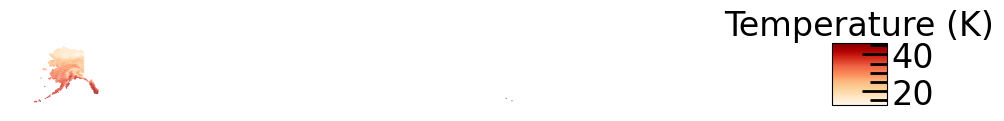

In [116]:
# the following plot is wacky due to CRS; Alaska crosses the international date line
fig, ax = plt.subplots(figsize=(15,15))

# Define the legend axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%",  pad=0.1)

# Plot the U.S. map with hexagons, where the colour represents the mean air temperature
zone_stats4.plot(column='mean', ax=ax, cmap='OrRd', legend=True, cax=cax)

# Customise the legend
cax.minorticks_on()
cax.tick_params(which='major', direction='in', length=18, width=2, labelsize=24)
cax.tick_params(which='minor', direction='in', length=12, width=2, labelsize=24)
cax.set_title('Temperature (K)', fontsize=24)

# Turn the x-axis and y-axis off
ax.set_axis_off()

In [117]:
zone_stats4_3338 = zone_stats4.to_crs(3338)

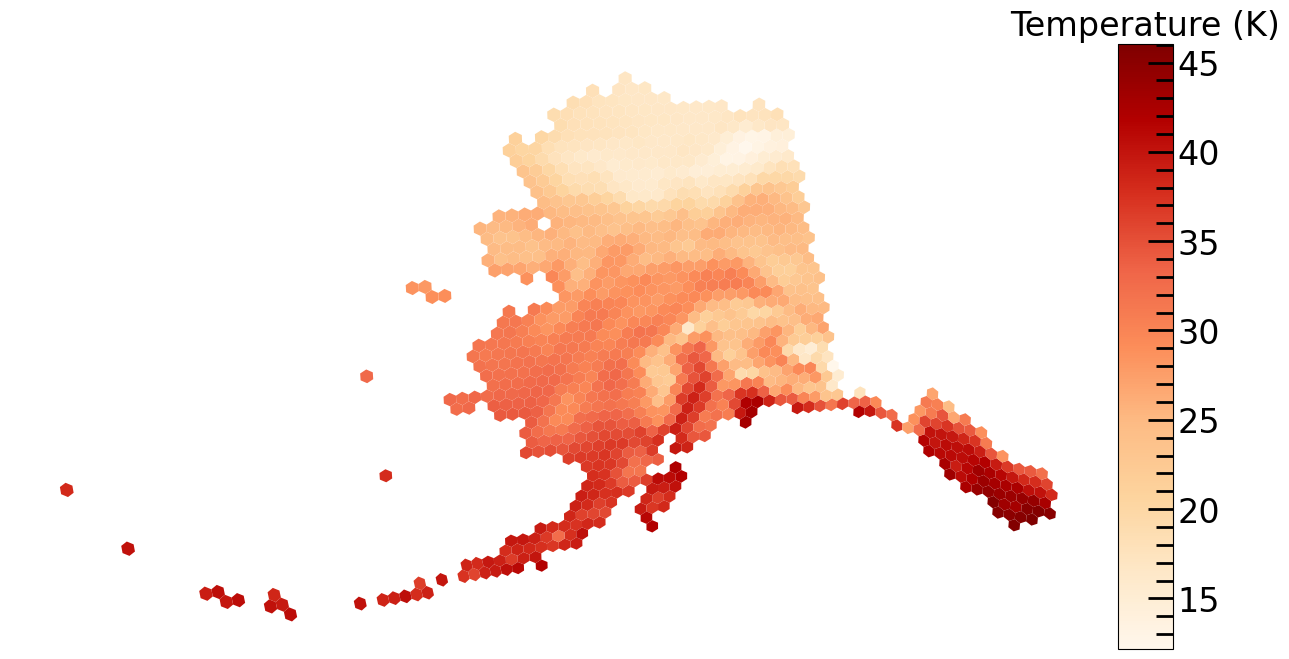

In [118]:
fig, ax = plt.subplots(figsize=(15,15))

# Define the legend axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%",  pad=0.1)

# Plot the U.S. map with hexagons, where the colour represents the mean air temperature
zone_stats4_3338.plot(column='mean', ax=ax, cmap='OrRd', legend=True, cax=cax)

# Customise the legend
cax.minorticks_on()
cax.tick_params(which='major', direction='in', length=18, width=2, labelsize=24)
cax.tick_params(which='minor', direction='in', length=12, width=2, labelsize=24)
cax.set_title('Temperature (K)', fontsize=24)

# Turn the x-axis and y-axis off
ax.set_axis_off()

Visualizing Resolution 5 is not possible due to the number of hexagons.

In [120]:
temp_map = zone_stats4_3338.explore(column='mean', name='Mean Temperature', cmap='OrRd', 
                              style_kwds={'opacity':0.4, 'color':'black', 'opacity':0.2}, 
                              highlight_kwds={'fillOpacity':1}, 
                              tooltip_kwds={'aliases':['Temperature']}, 
                              legend_kwds={'caption':'Mean Temperature (F)'})

# Add layer control to the map
folium.TileLayer('cartodbdark_matter',overlay=True,name="View in Dark Mode").add_to(temp_map)
folium.TileLayer('cartodbpositron',overlay=True,name="View in Light Mode").add_to(temp_map)
folium.LayerControl(collapsed=False).add_to(temp_map)

temp_map